# Data Science - ICARO
_________________________________
Clase: 22

Tema: Proyecto integrador - No Supervisado
_________________________________


## Objetivo:
- Aplicar algoritmos de Clustering (KMeans, DBSCAN) para descubrir agrupaciones naturales en el dataset "Wine Quality".
- Utilizar técnicas de Reducción de Dimensionalidad (PCA, t-SNE, UMAP) para visualizar la estructura de los datos y los clusters.
- Interpretar los resultados de los métodos no supervisados y las visualizaciones, extrayendo conclusiones sobre la organización intrínseca de los datos de vino.

---

## Índice

1. [Imports y Configuración Inicial](#imports)
2. [Carga y Preparación de Datos](#carga)
3. [Análisis Exploratorio de Datos (EDA)](#eda)
4. [**Tarea 1: Clustering (Descubrir Grupos de Vino)**](#clustering)
    - 4.1. [Preparación de Datos para Clustering](#prep_clustering)
    - 4.2. [Modelo de Clustering 1: KMeans](#kmeans)
    - 4.3. [Modelo de Clustering 2: DBSCAN](#dbscan)
    - 4.4. [**(A COMPLETAR) Tareas Finales de Clustering y Conclusión**](#conclusion_clustering)
5. [**Tarea 2: Reducción de Dimensionalidad y Visualización**](#reduccion_dim)
    - 5.1. [Preparación de Datos para Reducción de Dimensionalidad](#prep_reduccion)
    - 5.2. [Técnica de Reducción 1: PCA para Visualización](#pca)
    - 5.3. [Técnica de Reducción 2: t-SNE para Visualización](#tsne)
    - 5.4. [Técnica de Reducción 3: UMAP para Visualización](#umap)
    - 5.5. [**(A COMPLETAR) Tareas Finales de Reducción y Conclusión**](#conclusion_reduccion)
6. [**(A COMPLETAR) Conclusiones Finales del Proyecto**](#final)

---


<a name="imports"></a>
## 1. Imports y Configuración Inicial
En esta primera celda, importaremos todas las librerías que necesitaremos para nuestro análisis de modelos no supervisados.

In [1]:
!pip install umap-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Manipulación de datos
import pandas as pd
import numpy as np

In [4]:
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Modelos y Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap # Asegúrate de tener instalado 'umap-learn': pip install umap-learn

In [6]:
# Métricas de evaluación para clustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

In [7]:
# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10

In [8]:
def evaluar_k_clustering(data, max_k):
    """
    Calcula 4 métricas de clustering para un rango de K y devuelve los resultados.
    """
    k_range = range(2, max_k + 1)

    # Listas para almacenar los scores de cada métrica
    inercia_scores = []
    silueta_scores = []
    calinski_scores = []
    davies_bouldin_scores = []

    print(f"Evaluando K desde 2 hasta {max_k}...")

    for k in k_range:
        # Entrenar el modelo K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(data)
        labels = kmeans.labels_

        # Calcular y guardar las 4 métricas
        inercia_scores.append(kmeans.inertia_)
        silueta_scores.append(silhouette_score(data, labels))
        calinski_scores.append(calinski_harabasz_score(data, labels))
        davies_bouldin_scores.append(davies_bouldin_score(data, labels))

    # Crear un DataFrame con los resultados
    resultados_df = pd.DataFrame({
        'K': list(k_range),
        'Inercia': inercia_scores,
        'Silueta': silueta_scores,
        'Calinski-Harabasz': calinski_scores,
        'Davies-Bouldin': davies_bouldin_scores
    }).set_index('K')

    return resultados_df

In [76]:
def evaluar_dbscan(data, min_samples_eps):
    """
    Evalúa DBSCAN para distintos valores de min_samples y eps,
    calculando 3 métricas de clustering: Silhouette, Calinski-Harabasz y Davies-Bouldin.
    Ignora los puntos marcados como ruido (-1).
    """
    resultados = []

    print("Evaluando combinaciones de eps y min_samples...")

    for min_samples, eps in min_samples_eps.items():
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data)

        # Filtrar ruido
        mask = labels != -1
        
        if np.any(mask):
            n_clusters = len(set(labels[mask]))
        else:
            n_clusters = 0

        if n_clusters > 1:
            sil_score = silhouette_score(data[mask], labels[mask])
            calinski = calinski_harabasz_score(data[mask], labels[mask])
            davies = davies_bouldin_score(data[mask], labels[mask])
        else:
            sil_score = calinski = davies = np.nan

        resultados.append({
            'min_samples': min_samples,
            'eps': eps,
            'clusters_detectados': n_clusters,
            'Silhouette': sil_score,
            'Calinski-Harabasz': calinski,
            'Davies-Bouldin': davies
        })

        print(f"→ min_samples={min_samples}, eps={eps} | clusters={n_clusters}")

    resultados_df = pd.DataFrame(resultados).set_index(['min_samples', 'eps'])
    return resultados_df

---

<a name="carga"></a>
## 2. Carga y Preparación de Datos
Vamos a cargar los dos datasets (vino tinto y vino blanco), añadiremos una columna para identificar el tipo de vino y luego los uniremos en un único DataFrame.

Cargando dataframe de vinos tintos

In [10]:
# URLs del dataset de vinos tintos
url_red = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

# Carga del dataframe de vinos tintos
df_red = pd.read_csv(url_red, sep=';')

# Creación de la columna 'wine_type' (0 para tinto, 1 para blanco)
df_red['wine_type'] = 0

In [11]:
df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0


Cargando dataframe de vinos blancos

In [12]:
# URLs del dataset de vinos blancos
url_white = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# Carga del dataframe de vinos blancos
df_white = pd.read_csv(url_white, sep=';')

# Creación de la columna 'wine_type' (0 para tinto, 1 para blanco)
df_white['wine_type'] = 1

In [13]:
df_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


Unión de los dataframes

In [14]:
# Unión de los dataframes
df = pd.concat([df_red, df_white], axis=0)

# Reseteamos el índice
df.reset_index(drop=True, inplace=True)

print("Forma del dataset combinado:", df.shape)

display(df.head())

Forma del dataset combinado: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


---

<a name="eda"></a>
## 3. Análisis Exploratorio de Datos (EDA)
Antes de modelar, es crucial entender y preparar nuestros datos. Reutilizaremos el EDA básico del Módulo 2.

Información general del DataFrame

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


Estadísticas descriptivas de las variables numéricas

In [16]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


Valores nulos por columna

In [17]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
dtype: int64

Distribucíones de columna de interes

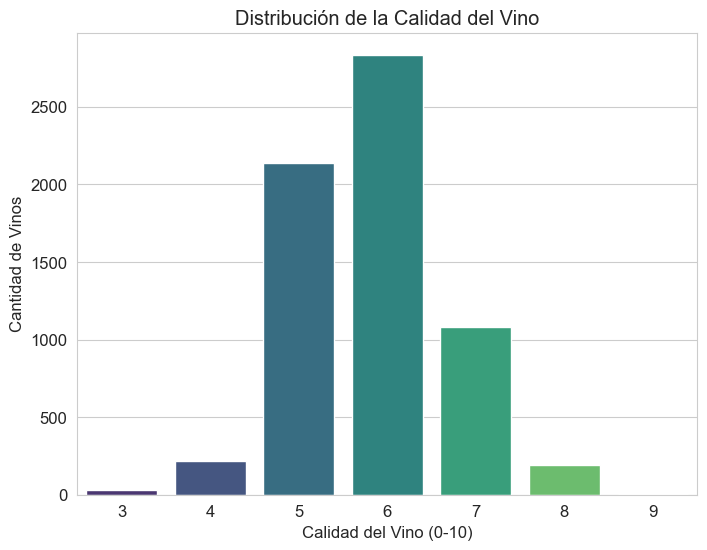

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Distribución de la Calidad del Vino')
plt.xlabel('Calidad del Vino (0-10)')
plt.ylabel('Cantidad de Vinos')
plt.show()

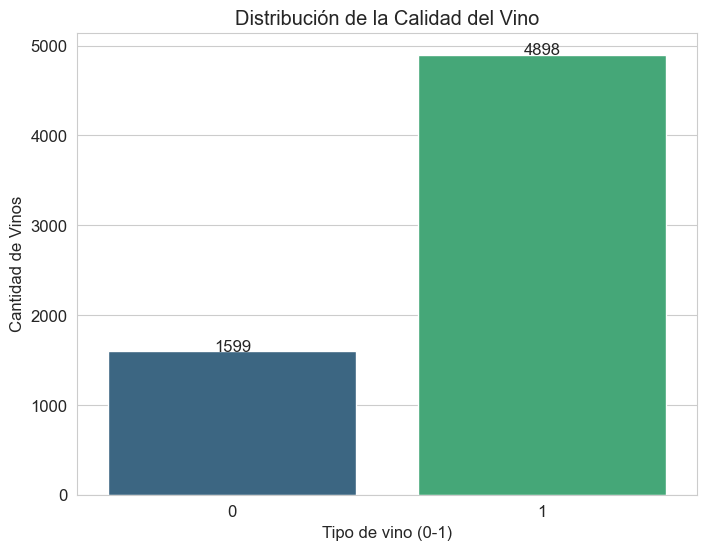

In [19]:
plt.figure(figsize=(8, 6))
ax = plt.axes()
sns.countplot(x='wine_type', data=df, palette='viridis', ax=ax)

# Ese bloque de código recorre cada barra, calcula el centro y la altura, y escribe encima el valor de la barra.
for patche_barra in ax.patches:
  x_bar = patche_barra.get_x()
  x_width_bar = patche_barra.get_width()
  y_heigth = patche_barra.get_height()
  plt.text(
      x_bar + x_width_bar / 2,
      y_heigth,
      int(y_heigth), ha='center')

plt.title('Distribución de la Calidad del Vino')
plt.xlabel('Tipo de vino (0-1)')
plt.ylabel('Cantidad de Vinos')
plt.show()

Correlaciones entre variables

In [20]:
# Excluimos las columnas 'wine_type' y 'quality' para la matriz de correlación de features
correlation_matrix = df.drop(['wine_type', 'quality'], axis=1).corr()
correlation_matrix

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029


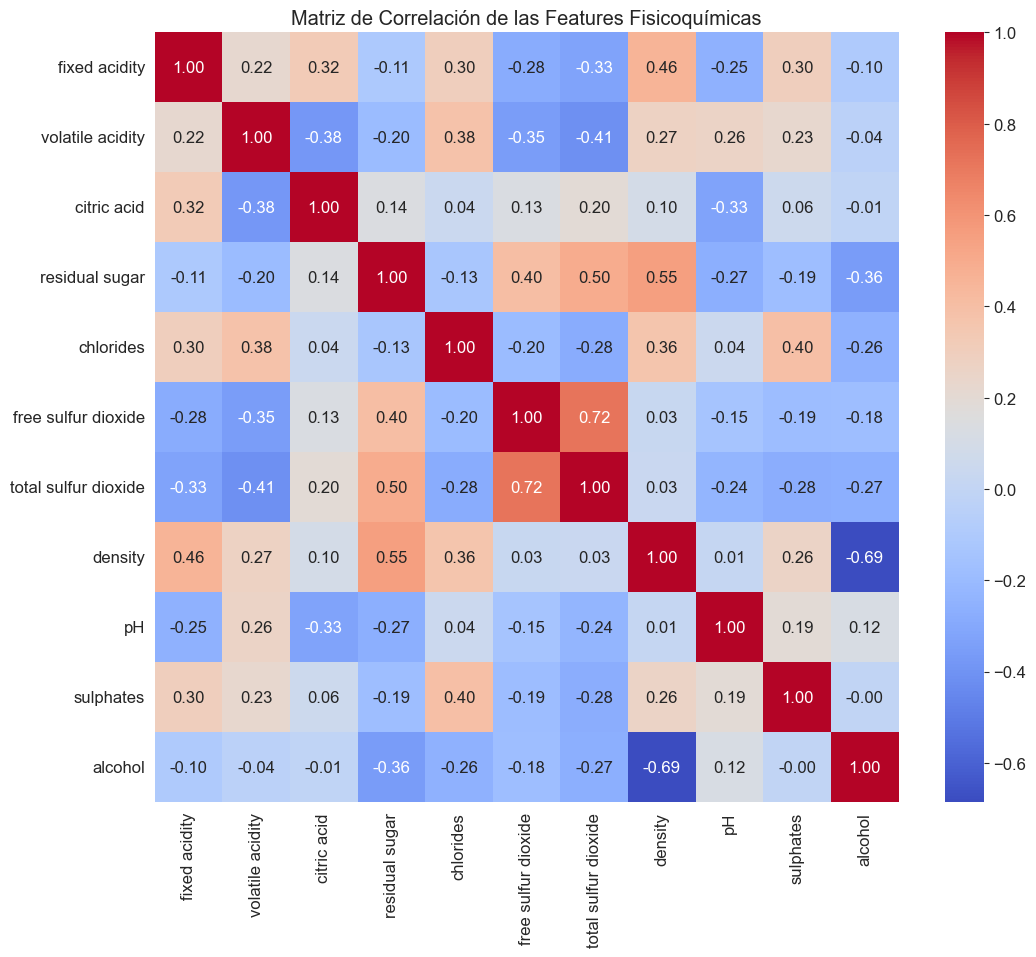

In [21]:
# Matriz de correlación de las variables fisicoquímicas
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de las Features Fisicoquímicas')
plt.show()

Valores atípicos

In [22]:
!pip install feature_engine

In [23]:
from feature_engine.outliers import Winsorizer

In [24]:
winsor = Winsorizer(capping_method='iqr', tail='both', fold=1.5)
number_columns = list(df.select_dtypes(include=['number']).columns)
number_columns.remove('wine_type')
df[number_columns] = winsor.fit_transform(df[number_columns])

### <font color=red>(A COMPLETAR) Análisis del EDA</font>
Basado en los resultados anteriores, comenta tus observaciones sobre:
- La distribución de las variables.
- La presencia de valores nulos (si los hay).
- Las correlaciones entre las características. ¿Hay alguna que te llame la atención?

--
<font color='green'>Respuesta:</font>

**Observaciones sobre la distribución de las variables:**

La mayoría de las variables presentan distribuciones sesgadas, lo que sugiere que no siguen una distribución normal. Además, se observan diferencias significativas en las escalas entre variables, lo cual podría indicar la presencia de valores atípicos y refuerza la necesidad de aplicar un proceso de escalado o normalización previo al modelado.

**Distribución por tipo de vino:**

La base de datos está compuesta principalmente por vinos blancos, con 4,898 observaciones, mientras que los vinos tintos representan 1,599 observaciones. Esta diferencia refleja un desequilibrio en la cantidad de muestras entre ambos tipos de vino.

No hay valores nulos explicitos dentro del dataset.

Una de las correlaciones más destacadas se observa entre las variables “density” y “alcohol”, lo que sugiere una posible covarianza significativa si se aplicaran métodos lineales. Esta relación indica que ambas variables podrían estar aportando información redundante al modelo. En este sentido, podría ser pertinente considerar técnicas de reducción de dimensionalidad, como PCA (Análisis de Componentes Principales), para eliminar redundancias y simplificar el espacio de características sin perder información relevante.

---

<a name="clustering"></a>
## 4. Tarea 1: Clustering (Descubrir Grupos de Vino)
En esta sección, aplicaremos algoritmos de clustering para identificar agrupaciones naturales dentro de nuestro dataset de vinos, sin utilizar las etiquetas de `wine_type` o `quality`.

<a name="prep_clustering"></a>
### 4.1. Preparación de Datos para Clustering
Para el clustering, solo usaremos las características fisicoquímicas de los vinos, y es **crucial** que estén escaladas. Las etiquetas originales (`wine_type`, `quality`) las guardaremos para una posterior comparación y análisis.

In [25]:
# Definir X (features) y las etiquetas originales (y_type, y_quality) para comparación
X = df.drop(['wine_type', 'quality'], axis=1)

y_type = df['wine_type']
y_quality = df['quality']

In [26]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.40,0.655,0.04,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.80,0.655,0.04,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.80,0.655,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,9.65,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.40,0.655,0.04,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.20,0.210,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
6493,6.60,0.320,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
6494,6.50,0.240,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
6495,5.50,0.290,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [27]:
# Escalar las características (fundamental para algoritmos basados en distancia)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pd.DataFrame(X_scaled, columns=X.columns).head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.241864,2.233152,-2.094714,-0.760343,1.069665,-1.144114,-1.451897,1.057459,1.851700,0.254091,-0.915758
1,0.617099,2.233152,-2.094714,-0.608610,2.103148,-0.315884,-0.865250,0.717517,-0.111713,1.168825,-0.580200
2,0.617099,2.233152,-2.094714,-0.673638,1.821289,-0.907477,-1.096353,0.785505,0.268303,0.940141,-0.580200
3,2.352562,-0.364438,1.849280,-0.760343,1.022688,-0.789158,-0.989690,1.125447,-0.365056,0.406547,-0.580200
4,0.241864,2.233152,-2.094714,-0.760343,1.069665,-1.144114,-1.451897,1.057459,1.851700,0.254091,-0.915758


<a name="kmeans"></a>
### 4.2. Modelo de Clustering 1: KMeans
KMeans es un algoritmo de clustering que busca dividir $N$ observaciones en $K$ clusters, donde cada observación pertenece al cluster con la media (centroide) más cercana. Es nuestro punto de partida para identificar grupos.

#### TAREAS EN EL NOTEBOOK:
1.  **Paso 1: Determinar K óptimo (Método del Codo).**
    * Iterar `K` desde 1 hasta 15 (o un rango similar).
    * Para cada `K`, entrenar un modelo `KMeans` con `X_scaled` y guardar la inercia.
    * Graficar la inercia vs. `K`.
    * Identificar el `K_elegido` donde la curva forma un "codo" y justificar su elección en un comentario markdown.

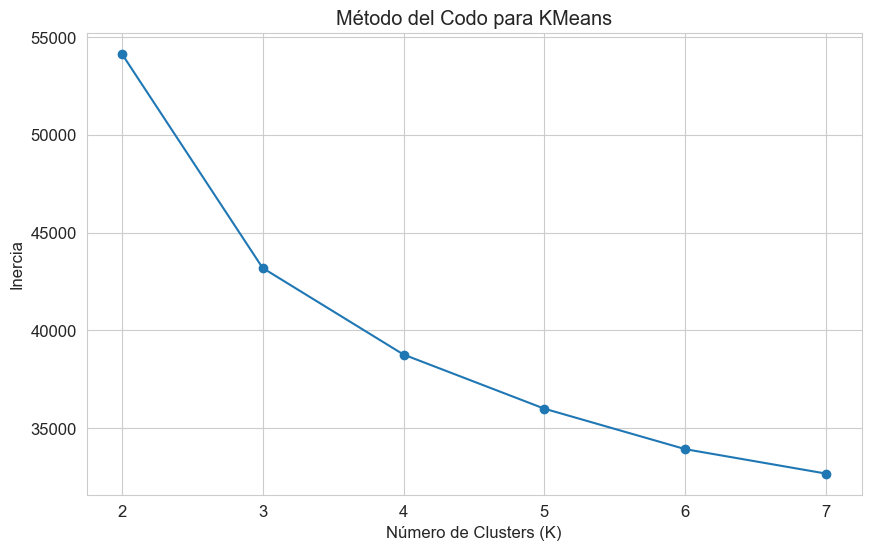

In [28]:
inertia = []
k_range = range(2, 8) # Probamos K desde 1 hasta 14

for k in k_range:
    # n_init='auto' es el valor por defecto para versiones recientes, o 10 para compatibilidad.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo para KMeans')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [29]:
!pip install kneed
!pip install yellowbrick

In [30]:
from kneed import KneeLocator

In [31]:
kl = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
print(f"El codo está en k = {kl.elbow}")

El codo está en k = 4


In [32]:
from yellowbrick.cluster import KElbowVisualizer

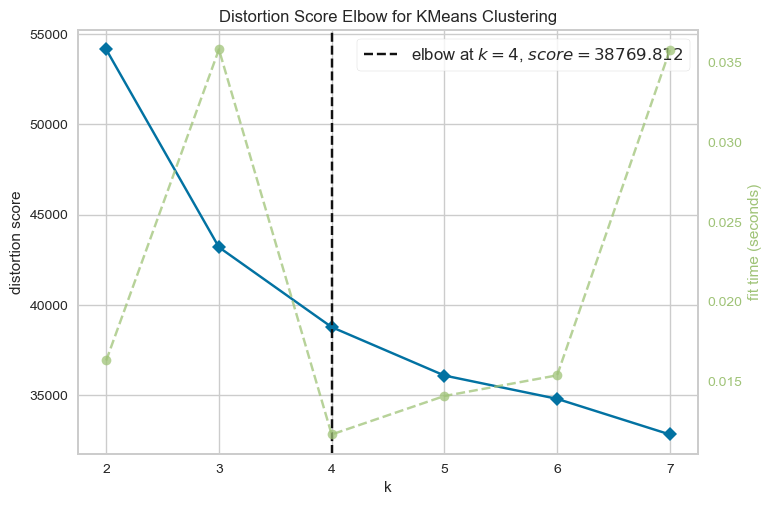

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=k_range)
visualizer.fit(X_scaled)
visualizer.show()

Metricas de separación

In [34]:
from yellowbrick.cluster import SilhouetteVisualizer

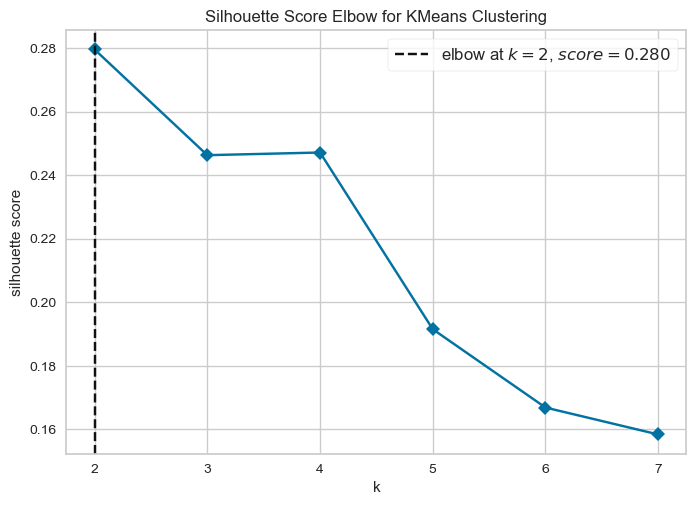

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [35]:
# ---Método de la silueta ---
silhouette = KElbowVisualizer(model, k=k_range, metric='silhouette', timings=False)
silhouette.fit(X_scaled)
silhouette.show()

Valor óptimo según la silueta: k = 2


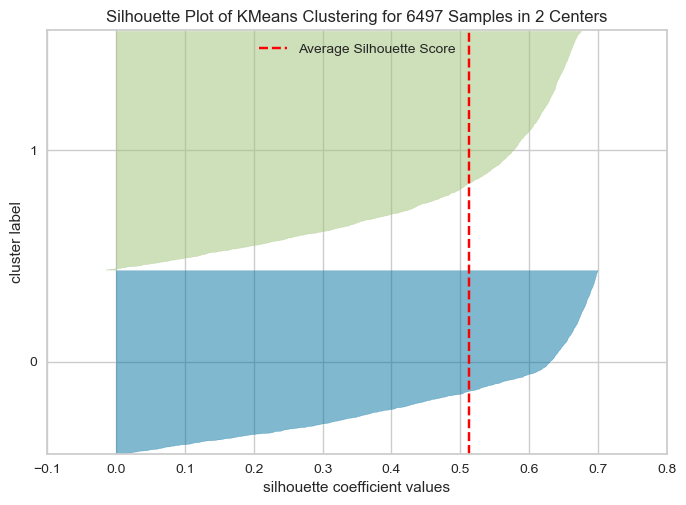

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 6497 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [36]:
best_k = silhouette.elbow_value_  # o el que elijas
print(f"Valor óptimo según la silueta: k = {best_k}")
kmeans = KMeans(n_clusters=best_k, random_state=42)

viz = SilhouetteVisualizer(kmeans, colors='yellowbrick')
viz.fit(X)
viz.show()

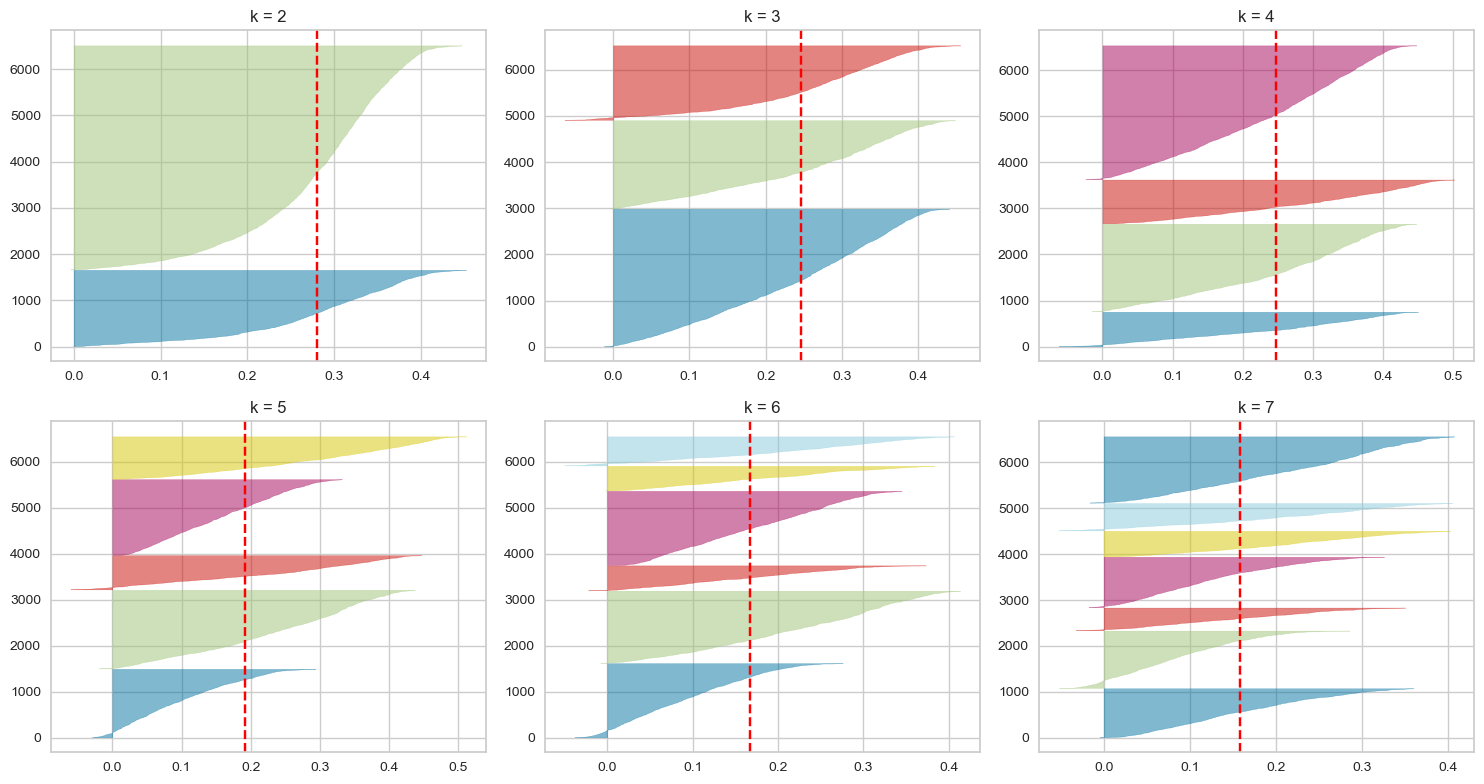

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, k in enumerate(k_range):
    model = KMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes[i])
    visualizer.fit(X_scaled)
    axes[i].set_title(f"k = {k}")

plt.tight_layout()
plt.show()

<font color=red>(A COMPLETAR) Justifica tu elección de K aquí</font>

> Por ejemplo: "Observando el gráfico del método del codo, el punto de inflexión más pronunciado parece estar en K = X. Por lo tanto, elegimos X clusters."

<font color='green'>Respuesta:</font>

**Primera iteración**

Al analizar el gráfico del método del codo, se observa que el punto de inflexión más marcado se encuentra en K = 4 o K = 6. Para resolver esta ambigüedad, se procederá a identificar y tratar los outliers, con el fin de evaluar si su manejo permite alcanzar un consenso entre las distintas librerías empleadas.

**Segunda iteración**

Tras reemplazar los outliers por el valor máximo anterior al límite superior del IQR, ambas librerías coinciden en que K = 4 representa el número óptimo de clusters. Este valor permite una reducción significativa de la inercia, manteniendo además la estabilidad y cohesión de los grupos. Se planifica una tercera iteración considerando métricas de separación, como el coeficiente de silueta, para complementar la evaluación.

**Tercera iteración**

El análisis mediante métricas de separación indica que, aunque K = 4 genera clusters con alta cohesión interna, esto no garantiza que los clusters estén bien diferenciados entre sí. En este punto, se podría considerar cualquier valor entre 2, 3 o 4 clusters. La decisión final se tomará tras aplicar técnicas de reducción de dimensionalidad, como t-SNE, para visualizar la separación y estructura real de los clusters.

In [38]:
k_elegido = 3 # Reemplaza None con el valor de K que elegiste

2.  **Paso 2: Ejecutar KMeans.**
    * Inicializar y entrenar `KMeans` con `n_clusters=K_elegido` y `random_state=42`.
    * Obtener las asignaciones de cluster usando `.fit_predict(X_scaled)`. Guardar en la variable `clusters_kmeans`.
    * Mostrar la cuenta de puntos por cluster (usando `pd.Series(clusters_kmeans).value_counts()`).

In [39]:
if k_elegido is not None:
    kmeans_final = KMeans(n_clusters=k_elegido, random_state=42, n_init=10)
    clusters_kmeans = kmeans_final.fit_predict(X_scaled)

    print(f"Número de puntos por cluster (KMeans con K={k_elegido}):")
    print(pd.Series(clusters_kmeans).value_counts().sort_index())
else:
    print("Por favor, define 'k_elegido' en la celda anterior.")

Número de puntos por cluster (KMeans con K=3):
0    2979
1    1611
2    1907
Name: count, dtype: int64


3.  **Paso 3: Evaluación de KMeans con Silhouette Score.**
    * Calcular y mostrar el `silhouette_score(X_scaled, clusters_kmeans)`.
    * Opcional: Calcular Calinski-Harabasz Score y Davies-Bouldin Score.

In [40]:
if 'clusters_kmeans' in locals():
    silhouette_avg_kmeans = silhouette_score(X_scaled, clusters_kmeans)
    print(f"Silhouette Score para KMeans (K={k_elegido}): {silhouette_avg_kmeans:.3f}")

    calinski_kmeans = calinski_harabasz_score(X_scaled, clusters_kmeans)
    davies_kmeans = davies_bouldin_score(X_scaled, clusters_kmeans)
    print(f"Calinski-Harabasz Score para KMeans: {calinski_kmeans:.3f}")
    print(f"Davies-Bouldin Score para KMeans: {davies_kmeans:.3f}")
else:
    print("Por favor, ejecuta las celdas anteriores para generar los clusters de KMeans.")

Silhouette Score para KMeans (K=3): 0.246
Calinski-Harabasz Score para KMeans: 2125.466
Davies-Bouldin Score para KMeans: 1.475


<font color=red>**Completar curvas de cada métrica**</font>

In [41]:
result_metricas = evaluar_k_clustering(X_scaled, 6)

Evaluando K desde 2 hasta 6...


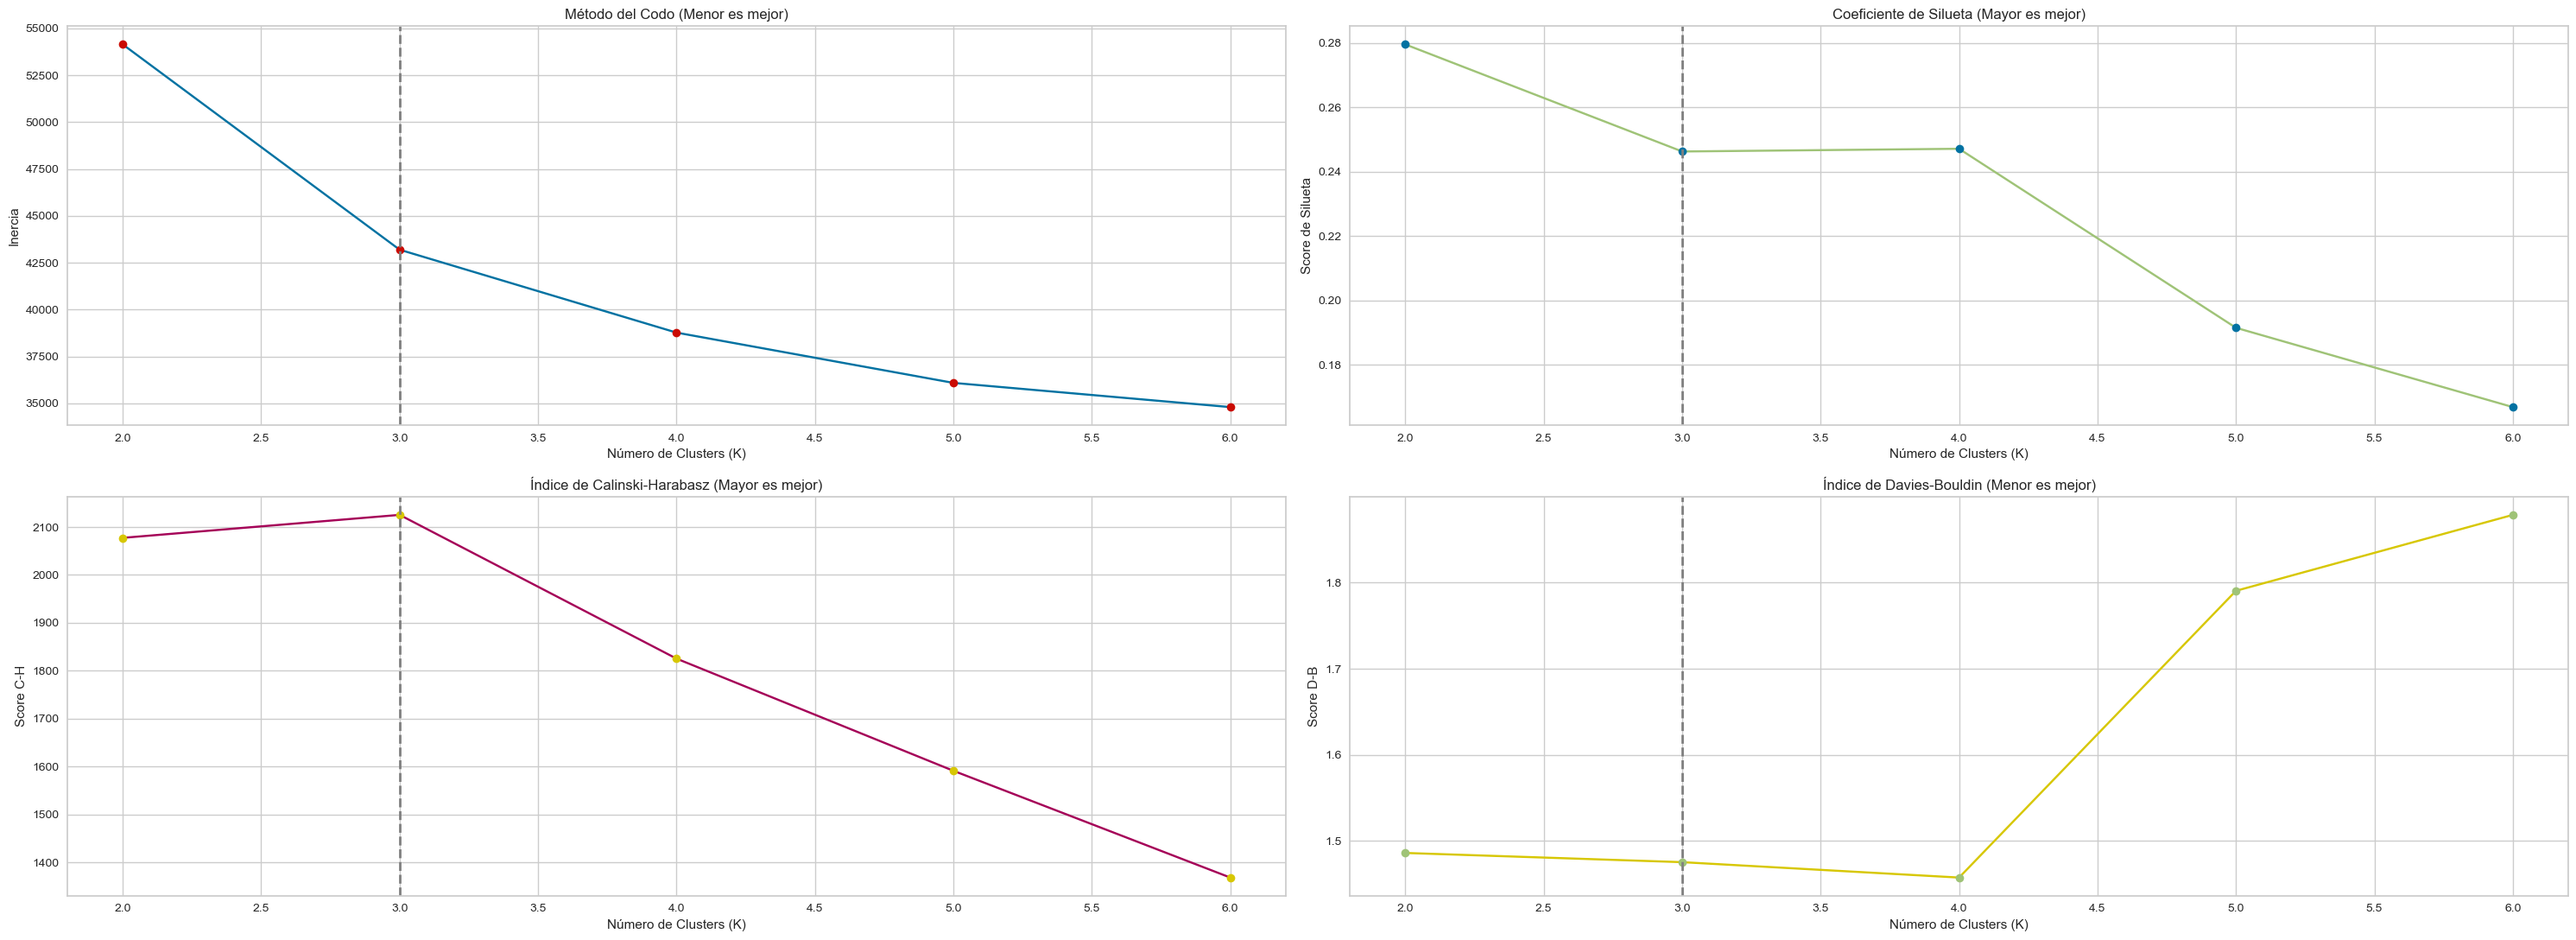

In [42]:
# Creamos una figura con 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(30, 12))

# fig.suptitle('Métricas de Evaluación para Datos Sintéticos', fontsize=16)

# 1. Gráfico del Método del Codo (Inercia) -> Menor es mejor, buscar el codo.
axes[0, 0].plot(result_metricas.index, result_metricas['Inercia'], 'bo-', markerfacecolor='r')
axes[0, 0].set_title('Método del Codo (Menor es mejor)')
axes[0, 0].set_xlabel('Número de Clusters (K)')
axes[0, 0].set_ylabel('Inercia')
axes[0, 0].axvline(x=k_elegido, color='grey', linestyle='--', linewidth=2)

# 2. Gráfico del Coeficiente de Silueta -> Mayor es mejor.
axes[0, 1].plot(result_metricas.index, result_metricas['Silueta'], 'go-', markerfacecolor='b')
axes[0, 1].set_title('Coeficiente de Silueta (Mayor es mejor)')
axes[0, 1].set_xlabel('Número de Clusters (K)')
axes[0, 1].set_ylabel('Score de Silueta')
axes[0, 1].axvline(x=k_elegido, color='grey', linestyle='--', linewidth=2)

# 3. Gráfico del Índice de Calinski-Harabasz -> Mayor es mejor.
axes[1, 0].plot(result_metricas.index, result_metricas['Calinski-Harabasz'], 'mo-', markerfacecolor='y')
axes[1, 0].set_title('Índice de Calinski-Harabasz (Mayor es mejor)')
axes[1, 0].set_xlabel('Número de Clusters (K)')
axes[1, 0].set_ylabel('Score C-H')
axes[1, 0].axvline(x=k_elegido, color='grey', linestyle='--', linewidth=2)

# 4. Gráfico del Índice de Davies-Bouldin -> Menor es mejor.
axes[1, 1].plot(result_metricas.index, result_metricas['Davies-Bouldin'], 'yo-', markerfacecolor='g')
axes[1, 1].set_title('Índice de Davies-Bouldin (Menor es mejor)')
axes[1, 1].set_xlabel('Número de Clusters (K)')
axes[1, 1].set_ylabel('Score D-B')
axes[1, 1].axvline(x=k_elegido, color='grey', linestyle='--', linewidth=2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<a name="dbscan"></a>
### 4.3. Modelo de Clustering 2: DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo basado en densidad que agrupa puntos que están densamente conectados, marcando como ruido los puntos que se encuentran en regiones de baja densidad.

#### TAREAS EN EL NOTEBOOK:
**Paso 1: Determinar `eps` y `min_samples` óptimos.**

    * Establecer un `min_samples` inicial (ej., `2 * numero_de_features` o 5).
    * Calcular las distancias al `min_samples`-ésimo vecino más cercano para cada punto.
    * Graficar estas distancias ordenadas.
    * Identificar el "codo" en el gráfico para estimar un `eps_elegido` y justificarlo en un comentario markdown.

In [43]:
# Para min_samples, un valor común es 2 * número_de_dimensiones, o simplemente 5.
# Para este dataset de vinos (11 dimensiones), usemos un min_samples inicial de 22 (2*11).
min_samples_dbscan = X_scaled.shape[1] + 1 # Experimenta con otros valores, ej. 5

Encontrar y ordenar las distancias al k-ésimo vecino más cercano

In [44]:
# Encontrar las distancias al k-ésimo vecino más cercano
neighbors = NearestNeighbors(n_neighbors=min_samples_dbscan)

In [45]:
neighbors_fit = neighbors.fit(X_scaled)

In [46]:
distances, indices = neighbors_fit.kneighbors(X_scaled)

In [47]:
indices, X_scaled.shape

(array([[   0,    4,    5, ..., 1551,  123, 1550],
        [   1,    2,  214, ...,  140,  135,  604],
        [   2,  214,    1, ..., 1386,  751,  750],
        ...,
        [6494, 2417, 2414, ..., 5570, 5568, 5316],
        [6495, 6170, 6140, ..., 6401, 4721, 3417],
        [6496, 4779, 4782, ..., 2990, 6170, 2464]], shape=(6497, 12)),
 (6497, 11))

In [48]:
# Se selecciona el k-ésimo vecino de cada punto (el que esta en la ultima columna de la matriz de distancias)
# Ordenar las distancias de estos k-esimos vecinos

distances = np.sort(distances[:, min_samples_dbscan-1], axis=0) # Indexamos min_samples-1 porque es el k-ésimo vecino

In [49]:
# distances: vector ordenado de distancias al k-ésimo vecino

knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
# knee.knee -> índice del codo detectado por KneeLocator dentro del vector de puntos.
index_ebow = knee.knee
# Extrae la distancia correspondiente a ese índice, que se usará como eps óptimo para DBSCAN.
eps_optimo = distances[index_ebow] 
print("eps óptimo:", eps_optimo)

eps óptimo: 3.074696869345552


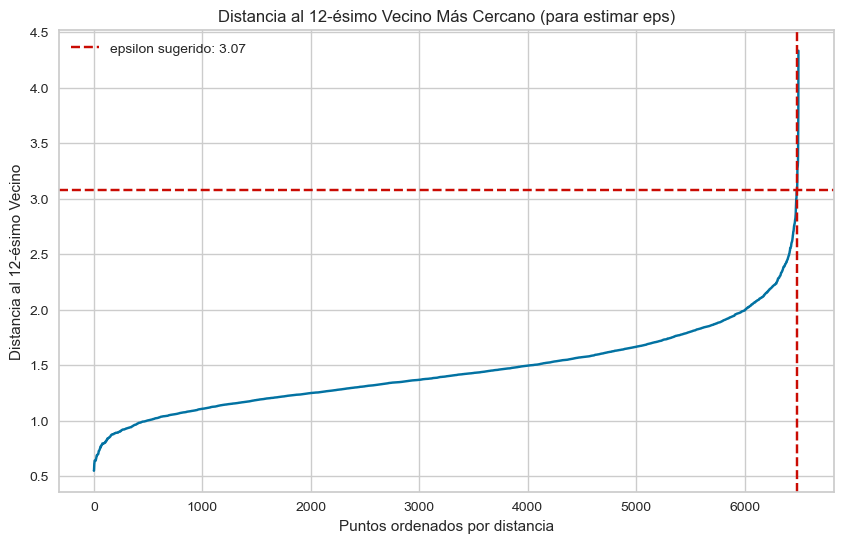

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axvline(index_ebow, color='r', linestyle='--')
plt.axhline(eps_optimo, color='r', linestyle='--', label=f'epsilon sugerido: {round(eps_optimo, 2)}')
plt.title(f'Distancia al {min_samples_dbscan}-ésimo Vecino Más Cercano (para estimar eps)')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'Distancia al {min_samples_dbscan}-ésimo Vecino')
plt.legend()
plt.grid(True)
plt.show()

<font color=red>(A COMPLETAR) Justifica tu elección de eps aquí</font>

Por ejemplo: "Observando el gráfico de distancias, el 'codo' más pronunciado parece estar alrededor de eps = Y. Por lo tanto, elegimos Y."

<font color='green'>Respuesta:</font>

Conclusión sobre DBSCAN

**Primera iteración:**
Se eligió un valor de epsilon de 2.77, determinado aplicando la heurística de min_samples = num_features × 2. Sin embargo, la ejecución inicial mostró que DBSCAN formaba un único cluster predominante, lo cual contrasta significativamente con los resultados obtenidos mediante K-Means y con las expectativas sobre la presencia de agrupamientos latentes en los datos. Esto motivó una segunda iteración ajustando min_samples.

**Segunda iteración:**
Se evaluaron min_samples = 5 y min_samples = 10, obteniéndose eps de 2.22 y 2.55 respectivamente. A pesar de estos ajustes, los resultados siguieron mostrando un único cluster predominante acompañado de puntos aislados (outliers), sin mejorar la capacidad de detección de agrupamientos significativos. Esto llevó a investigar más a fondo las heurísticas sugeridas en la literatura para elegir min_samples.

**Tercera iteración:**
Se consideraron las dos heurísticas más recomendadas:
1.	Regla básica: min_samples ≈ D + 1
- Fuente: Ester et al., 1996 (KDD).
- Recomienda que minPts (equivalente a min_samples en Sklearn) sea al menos la dimensión de los datos más uno.

2.	Incremento para robustez frente al ruido: min_samples ≈ 2D o 3D
- Fuente: Schubert et al., 2017 (TODS).
- Recomienda aumentar min_samples en presencia de ruido o outliers para obtener clusters más confiables.

Aun aplicando estas heurísticas y combinándolas con la técnica del knee para determinar eps, DBSCAN continuó generando un cluster principal sobrecargado con el resto de los puntos clasificados como ruido, sin identificar agrupamientos coherentes.

**Conclusión final:**
Debido a que DBSCAN no logra separar adecuadamente los clusters en este conjunto de datos, y considerando que K-Means proporciona agrupamientos más consistentes y estables, se opta por adoptar los resultados de K-Means como la solución final para la segmentación de los datos.


In [51]:
eps_elegido = 3.07 # Reemplaza None con el valor de eps que elegiste

**Paso 2: Ejecutar DBSCAN.**

    * Inicializar y entrenar `DBSCAN` con `eps=eps_elegido` y `min_samples=min_samples_dbscan`.
    * Obtener las asignaciones de cluster usando `.fit_predict(X_scaled)`. Guardar en `clusters_dbscan`.
    * Mostrar la cuenta de puntos por cluster, destacando el cluster `-1` (ruido).

In [52]:
if eps_elegido is not None:
    dbscan_final = DBSCAN(eps=eps_elegido, min_samples=min_samples_dbscan)
    clusters_dbscan = dbscan_final.fit_predict(X_scaled)

    print(f"Número de puntos por cluster (DBSCAN con eps={eps_elegido}, min_samples={min_samples_dbscan}):")
    print(pd.Series(clusters_dbscan).value_counts().sort_index())
else:
    print("Por favor, define 'eps_elegido' en la celda anterior.")

Número de puntos por cluster (DBSCAN con eps=3.07, min_samples=12):
-1       2
 0    6495
Name: count, dtype: int64


**Paso 3: Evaluación de DBSCAN con Silhouette Score (excluyendo ruido).**

    * Calcular y mostrar el `silhouette_score` para DBSCAN, **excluyendo los puntos clasificados como ruido** (`clusters_dbscan != -1`).
    * Opcional: Calcular Calinski-Harabasz Score y Davies-Bouldin Score (excluyendo ruido).

In [53]:
if 'clusters_dbscan' in locals():
    valid_indices = clusters_dbscan != -1
    if np.unique(clusters_dbscan[valid_indices]).size > 1: # Asegurarse de que haya al menos 2 clusters válidos
        silhouette_avg_dbscan = silhouette_score(X_scaled[valid_indices], clusters_dbscan[valid_indices])
        print(f"Silhouette Score para DBSCAN (excluyendo ruido): {silhouette_avg_dbscan:.3f}")

        calinski_dbscan = calinski_harabasz_score(X_scaled[valid_indices], clusters_dbscan[valid_indices])
        davies_dbscan = davies_bouldin_score(X_scaled[valid_indices], clusters_dbscan[valid_indices])
        print(f"Calinski-Harabasz Score para DBSCAN: {calinski_dbscan:.3f}")
        print(f"Davies-Bouldin Score para DBSCAN: {davies_dbscan:.3f}")
    else:
        print("No hay suficientes clusters válidos (más de 1) en DBSCAN para calcular Silhouette Score.")
else:
    print("Por favor, ejecuta las celdas anteriores para generar los clusters de DBSCAN.")

No hay suficientes clusters válidos (más de 1) en DBSCAN para calcular Silhouette Score.


<font color=red>**Completar curvas de cada métrica**</font>

In [77]:
min_samples_eps = {
22:2.77,
5: 2.22,
10:2.55,
33: 3.07
}

In [78]:
result_metricas = evaluar_dbscan(X_scaled, min_samples_eps)

Evaluando combinaciones de eps y min_samples...
→ min_samples=22, eps=2.77 | clusters=1
→ min_samples=5, eps=2.22 | clusters=1
→ min_samples=10, eps=2.55 | clusters=1
→ min_samples=33, eps=3.07 | clusters=1


In [79]:
result_metricas

,,clusters_detectados,Silhouette,Calinski-Harabasz,Davies-Bouldin
min_samples,eps,,,,
22,2.77,1,NaN,NaN,NaN
5,2.22,1,NaN,NaN,NaN
10,2.55,1,NaN,NaN,NaN
33,3.07,1,NaN,NaN,NaN


Si hay solo un cluster, no se pueden calcular las métricas de calidad (porque todas requieren al menos 2 clusters).

<a name="conclusion_clustering"></a>
### 4.4. (A COMPLETAR) Tareas Finales de Clustering y Conclusión
No basta con aplicar los algoritmos; es crucial entender qué nos dicen los clusters y cuál enfoque es más adecuado para nuestro dataset de vinos.

#### TAREAS EN EL NOTEBOOK:
1.  **Métricas Clave:**
    * Recopilen los `Silhouette Score` de KMeans y DBSCAN. ¿Cuál algoritmo obtuvo un mejor score y qué implica en términos de cohesión y separación de clusters?

In [56]:
print("\n--- Comparación de Métricas de Clustering ---")
if 'silhouette_avg_kmeans' in locals():
    print(f"KMeans (K={k_elegido}): Silhouette Score = {silhouette_avg_kmeans:.3f}")
if 'silhouette_avg_dbscan' in locals():
    print(f"DBSCAN (eps={eps_elegido}, min_samples={min_samples_dbscan}): Silhouette Score = {silhouette_avg_dbscan:.3f}")


--- Comparación de Métricas de Clustering ---
KMeans (K=3): Silhouette Score = 0.246


<font color=red>(A COMPLETAR) Compara y comenta los scores aquí:</font>

"Basado en el Silhouette Score, [KMeans/DBSCAN] parece generar clusters con mejor separación y cohesión interna debido a..."

<font color='green'>Respuesta: </font>

Basándonos en los resultados obtenidos, tanto a nivel de agrupamiento como en las métricas de evaluación, K-Means demuestra ser significativamente más efectivo para detectar los clusters en este conjunto de datos. El algoritmo logra identificar grupos consistentes, con una distribución equilibrada de registros en cada cluster. Esta superioridad se refleja claramente en las métricas de cohesión y separación, tal como se detalló en la sección correspondiente, lo que respalda la elección de K-Means como la técnica más adecuada para esta segmentación.

2.  **Análisis de Clusters vs. Etiquetas Originales:**
    * Para el clustering que consideren "mejor" o más interesante, analicen la distribución de las etiquetas `y_type` (tipo de vino: tinto/blanco) y `y_quality` (calidad del vino) dentro de cada cluster.
    * Pueden usar `pd.crosstab()` o gráficos de barras/conteo para visualizar esto.
    * ¿Hay algún cluster que sea predominantemente de un tipo de vino o de una calidad particular?

In [57]:
# (A COMPLETAR) Elige el conjunto de clusters que consideres más interesante (ej. clusters_kmeans o clusters_dbscan)
clusters_para_analisis = clusters_kmeans # O clusters_dbscan

if 'clusters_para_analisis' in locals():
    # Análisis de clusters vs. Tipo de Vino
    print("\n--- Análisis de Clusters vs. Tipo de Vino Original ---")
    crosstab_type = pd.crosstab(clusters_para_analisis, y_type)
    display(crosstab_type)

    # Análisis de clusters vs. Calidad del Vino
    print("\n--- Análisis de Clusters vs. Calidad del Vino Original ---")
    crosstab_quality = pd.crosstab(clusters_para_analisis, y_quality)
    display(crosstab_quality)
else:
    print("Por favor, asegúrate de que 'clusters_kmeans' o 'clusters_dbscan' estén definidos.")


--- Análisis de Clusters vs. Tipo de Vino Original ---


wine_type,0,1
row_0,,
0,47,2932
1,1547,64
2,5,1902



--- Análisis de Clusters vs. Calidad del Vino Original ---


quality,3.5,4.0,5.0,6.0,7.0,7.5
row_0,,,,,,
0,8,97,627,1361,731,155
1,10,71,700,625,189,16
2,12,48,811,850,159,27


<font color=red>(A COMPLETAR) Comenta tus observaciones sobre estos cruces:</font>

"Observamos que el cluster X tiene una alta proporción de vinos [tintos/blancos]..."

"En cuanto a la calidad, el cluster Y parece agrupar vinos de [alta/baja/media] calidad..."

3.  **Completar la Tabla de Resultados de Clustering:**
    * Llenen la siguiente tabla resumen con los resultados de ambos algoritmos.

| Algoritmo | Parámetros Clave (K / eps, min_samples) | Nº Clusters Encontrados | Nº Outliers (DBSCAN) | Silhouette Score |
|-----------|-----------------------------------------|-------------------------|----------------------|------------------|
| KMeans    | `K = [Tu K]`                            | `[Tu Nº Clusters]`      | N/A                  | `[Tu Score]`     |
| DBSCAN    | `eps = [Tu eps], min_samples = [Tu min_samples]` | `[Tu Nº Clusters]`      | `[Tu Nº Outliers]`   | `[Tu Score]`     |

4.  **Justificar:**
    * Escriban una conclusión clara: ¿Qué algoritmo de clustering (KMeans o DBSCAN) eligen como el más "revelador" o útil para este dataset y por qué?
    * Consideren la calidad de los clusters, la interpretabilidad de los resultados, la capacidad de manejar formas no esféricas y su capacidad para encontrar patrones significativos.

<font color=red>(A COMPLETAR) Conclusión sobre el Mejor Algoritmo de Clustering:</font>
```

Basado en [métricas de evaluación, análisis de clusters vs. etiquetas originales, y observaciones visuales], considero que el algoritmo [KMeans / DBSCAN] es el más adecuado para descubrir la estructura natural de este dataset de vinos porque...

```

<font color='green'>Respuesta:</font>

**Conclusión sobre los resultados obtenidos:**

Al analizar la composición de los clusters, se observa que el Cluster 1 y el Cluster 3 contienen principalmente vinos blancos, mientras que el Cluster 2 está compuesto mayoritariamente por vinos tintos. Dado que contamos con las etiquetas, esta separación sugiere que la división más natural podría ser de dos clusters, aunque K-Means identificó tres agrupamientos consistentes.

En cuanto a la variable de calidad, la distribución de registros se mantiene relativamente equilibrada entre los clusters, lo que indica que la segmentación no está sesgada por el tamaño de los grupos.

**Tabla de resultados:**

| Algoritmo | Parámetros Clave (K / eps, min_samples) | Nº Clusters Encontrados | Nº Outliers (DBSCAN) | Silhouette Score |
|-----------|-----------------------------------------|------------------------|---------------------|-----------------|
| KMeans    | `K = 3` (a definir entre 2 y 4)         | 3                      | N/A                 | 0.246           |
| DBSCAN    | `eps = 3.07, min_samples = 12`          | 1 (más outliers)       | 2                   | N/A (insuficientes clusters) |

**Elección del mejor algoritmo:**

Basándonos en la composición de los clusters, la coherencia interna y las métricas de evaluación, K-Means se mantiene como el algoritmo más adecuado para este conjunto de datos. Sin embargo, la determinación del número óptimo de clusters (entre 2 y 4) sigue siendo un aspecto abierto en escenarios sin etiquetas reales. Esto resalta la importancia de complementar el clustering con técnicas de reducción de dimensionalidad, que permitan obtener una representación visual de los datos, tanto en su estructura natural como segmentados según los clusters encontrados. Además, es recomendable integrar un análisis descriptivo del contexto para interpretar los resultados y tomar decisiones finales de manera fundamentada.

<a name="reduccion_dim"></a>
## 5. Tarea 2: Reducción de Dimensionalidad y Visualización
Dado que nuestros datos tienen 11 características, es difícil visualizarlos. Aplicaremos técnicas de reducción de dimensionalidad para proyectar los datos a 2 dimensiones, permitiéndonos ver la estructura de los clusters encontrados.

> **Observación general sobre la superposición entre tipos de vino**
> 
> La superposición observada entre muestras de vino blanco y vino tinto puede explicarse por diversos factores. En primer lugar, algunas muestras podrían representar valores atípicos dentro de su propia clase, ya sea por pertenecer a variedades específicas o por reflejar anomalías en el proceso de producción.
> 
> En segundo lugar, es importante considerar que los métodos de reducción de dimensionalidad no supervisados (como PCA o t-SNE) generan una proyección aproximada del espacio original en dos dimensiones, lo que implica una pérdida parcial de información. Por ello, la representación visual resultante no siempre refleja con exactitud la separación real entre clases.
> 
> Como paso siguiente, se recomienda realizar un tratamiento de outliers por variable y, posteriormente, explorar técnicas supervisadas de reducción de dimensionalidad, como LDA (Linear Discriminant Analysis), o métodos no lineales como UMAP, para evaluar si se obtiene una mejor separación entre los tipos de vino en el espacio reducido.


> **Observación general sobre las particiones internas en baja dimensión**
> 
> En la representación de los datos en baja dimensión, se observan subdivisiones dentro de los grupos principales correspondientes a cada tipo de vino. Estas particiones coinciden con los clusters identificados en el análisis de agrupamiento, lo que sugiere la posible existencia de subgrupos o categorías adicionales dentro de cada tipo de vino.
> 
> Esto podría indicar la presencia de subtipos de vinos pertenecientes a una misma variedad —por ejemplo, distintos estilos de vino blanco o tinto—, o incluso la existencia de otras clases intermedias, como vinos rosados o mezclas particulares. En este sentido, estos patrones podrían reflejar variabilidad en las características físico-químicas o diferencias en los procesos de producción, aportando información valiosa para un análisis más detallado.


<a name="prep_reduccion"></a>
### 5.1. Preparación de Datos para Reducción de Dimensionalidad
La entrada para las técnicas de reducción de dimensionalidad serán los datos escalados (`X_scaled`) que preparamos previamente.

In [58]:
print(f"Los datos de entrada para la reducción de dimensionalidad son X_scaled con forma: {X_scaled.shape}")

Los datos de entrada para la reducción de dimensionalidad son X_scaled con forma: (6497, 11)


<a name="pca"></a>
### 5.2. Técnica de Reducción 1: PCA para Visualización
PCA (Principal Component Analysis) es una técnica de reducción de dimensionalidad lineal que busca las direcciones (componentes principales) en los datos que maximizan la varianza.

#### TAREAS EN EL NOTEBOOK:
**Paso 1: Aplicar PCA.**

    * Inicializar `PCA(n_components=2, random_state=42)`.
    * Entrenar y transformar `X_scaled` usando `.fit_transform()`. Guardar en `X_pca`.

In [59]:
pca = PCA(n_components=2, random_state=42)

In [60]:
X_pca = pca.fit_transform(X_scaled)

In [61]:
X_pca

array([[-3.59450276,  0.23399545],
       [-3.27545627,  0.98896422],
       [-3.54820125,  0.70508925],
       ...,
       [ 0.76023036, -0.69224147],
       [ 0.89773375, -3.73147032],
       [ 1.28897526, -3.01806616]], shape=(6497, 2))

**Paso 2: Visualizar Clusters de KMeans en PCA.**

    * Crear un `scatter plot` de `X_pca` coloreado por `clusters_kmeans`.
    * Añadir título, etiquetas de ejes y una barra de color.

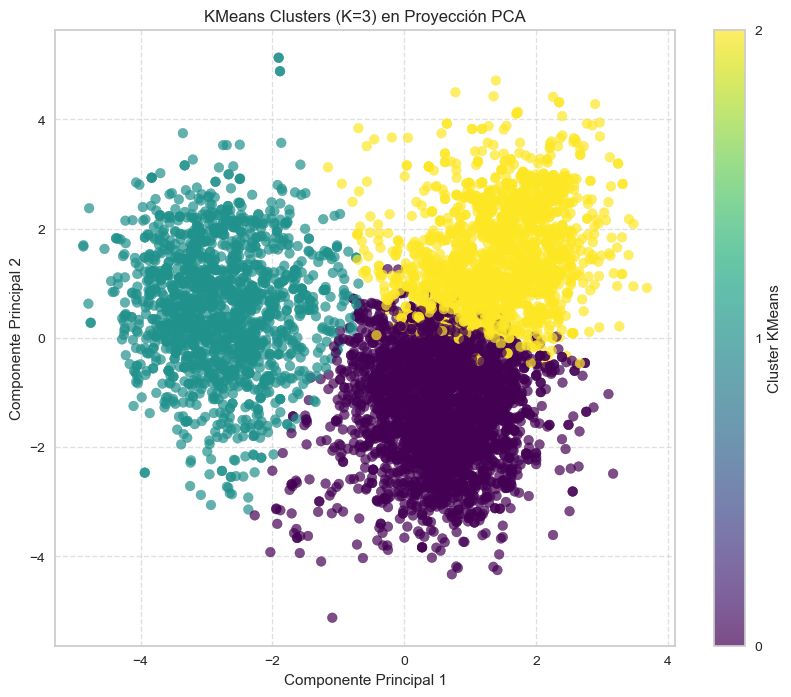

In [62]:
if 'clusters_kmeans' in locals():
    plt.figure(figsize=(10, 8))
    scatter_kmeans_pca = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
    plt.title(f'KMeans Clusters (K={k_elegido}) en Proyección PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.colorbar(scatter_kmeans_pca, label='Cluster KMeans', ticks=range(k_elegido))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de KMeans para obtener 'clusters_kmeans'.")

**Paso 3: Visualizar Clusters de DBSCAN en PCA.**

    * Crear un `scatter plot` de `X_pca` coloreado por `clusters_dbscan`.
    * Añadir título, etiquetas de ejes y una barra de color.

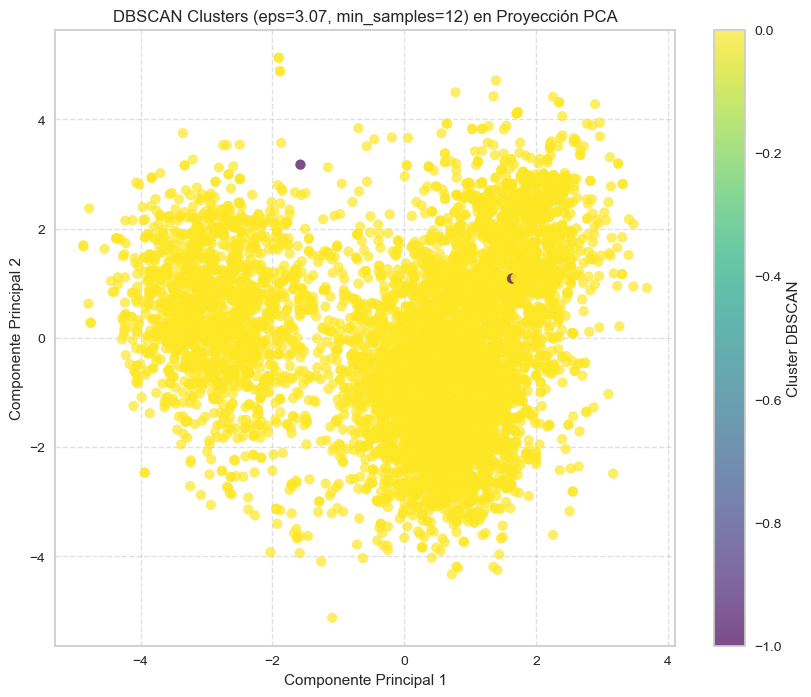

In [63]:
if 'clusters_dbscan' in locals():
    plt.figure(figsize=(10, 8))
    scatter_dbscan_pca = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.7)
    plt.title(f'DBSCAN Clusters (eps={eps_elegido}, min_samples={min_samples_dbscan}) en Proyección PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.colorbar(scatter_dbscan_pca, label='Cluster DBSCAN')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de DBSCAN para obtener 'clusters_dbscan'.")

**Paso 4: Comparación con Tipo de Vino Original.**

    * Crear un `scatter plot` de `X_pca` coloreado por `y_type` (la etiqueta original de tinto/blanco).
    * Añadir título, etiquetas de ejes y una barra de color interpretativa.
    * Comentar las observaciones sobre la separación.

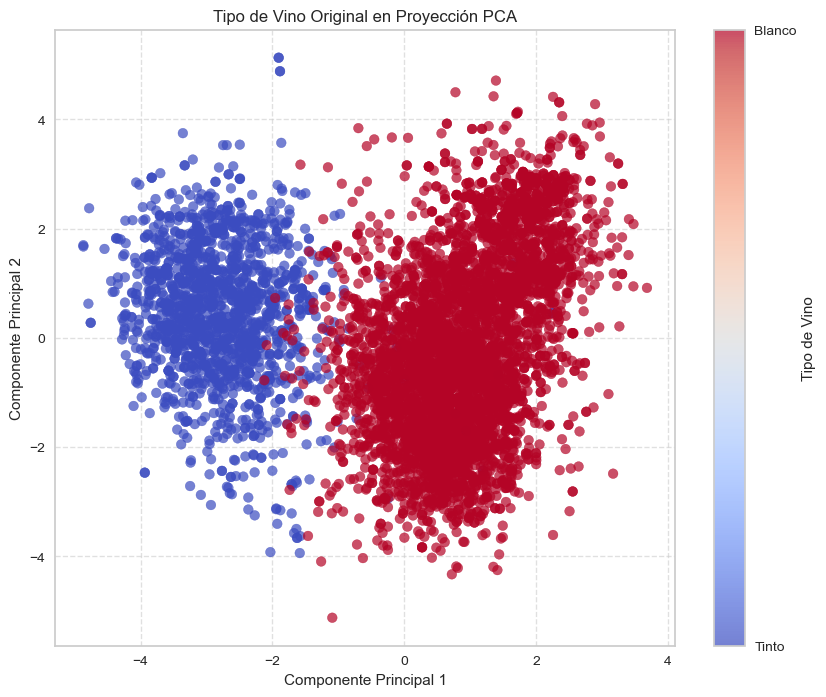

In [64]:
plt.figure(figsize=(10, 8))
scatter_original_pca = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_type, cmap='coolwarm', alpha=0.7)
plt.title('Tipo de Vino Original en Proyección PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter_original_pca, ticks=[0, 1], format=plt.FuncFormatter(lambda x, p: 'Tinto' if x==0 else 'Blanco'), label='Tipo de Vino')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

<font color=red>(A COMPLETAR) Comenta aquí tus observaciones sobre la separación con PCA</font>

"PCA logra [una buena/mala] separación visual de los vinos por tipo, lo que indica..."

"Los clusters encontrados por KMeans/DBSCAN se [alinean/no alinean] bien con la separación de PCA..."

<font color='green'>Respuesta:</font>

PCA no es un algoritmo diseñado para separar clases o descubrir agrupamientos subyacentes; su objetivo principal es capturar la mayor varianza de los datos en dimensiones reducidas. No obstante, al analizar los resultados en baja dimensión, se observa que los patrones visualizados respaldan parcialmente lo detectado mediante el Silhouette Score usando Yellowbrick, considerando un número de clusters igual a 3.

En este escenario, dos de los clusters presentan cierta superposición en algunos puntos, lo cual podría ser válido dependiendo del contexto y requiere un análisis descriptivo profundo del dominio para determinar si es apropiado realizar una separación más fina.

Con la reducción de dimensionalidad y la visualización de agrupamientos latentes, será posible evaluar de manera más clara la estructura de los datos y decidir si es adecuado optar por K = 2 como número final de clusters.

<a name="tsne"></a>
### 5.3. Técnica de Reducción 2: t-SNE para Visualización
t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica no lineal que se enfoca en preservar las relaciones de proximidad local, lo que la hace excelente para visualizar agrupamientos (clusters).

#### TAREAS EN EL NOTEBOOK:
**Paso 1: Aplicar t-SNE.**

    * Inicializar `TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)`.
    * Entrenar y transformar `X_scaled` usando `.fit_transform()`. Guardar en `X_tsne`. (¡Este paso puede tardar varios segundos/minutos!).

In [65]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

In [66]:
X_tsne = tsne.fit_transform(X_scaled)

**Paso 2: Visualizar Clusters de KMeans en t-SNE.**

    * Crear un `scatter plot` de `X_tsne` coloreado por `clusters_kmeans`.
    * Añadir título, etiquetas de ejes y una barra de color.

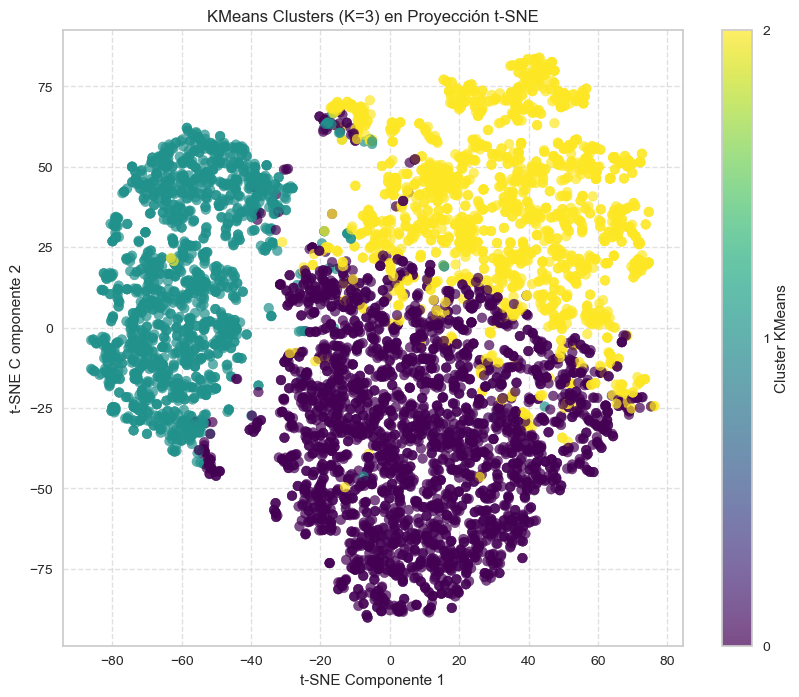

In [67]:
if 'clusters_kmeans' in locals():
    plt.figure(figsize=(10, 8))
    scatter_kmeans_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
    plt.title(f'KMeans Clusters (K={k_elegido}) en Proyección t-SNE')
    plt.xlabel('t-SNE Componente 1')
    plt.ylabel('t-SNE C omponente 2')
    plt.colorbar(scatter_kmeans_tsne, label='Cluster KMeans', ticks=range(k_elegido))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de KMeans para obtener 'clusters_kmeans'.")

**Paso 3: Visualizar Clusters de DBSCAN en t-SNE.**

    * Crear un `scatter plot` de `X_tsne` coloreado por `clusters_dbscan`.
    * Añadir título, etiquetas de ejes y una barra de color.

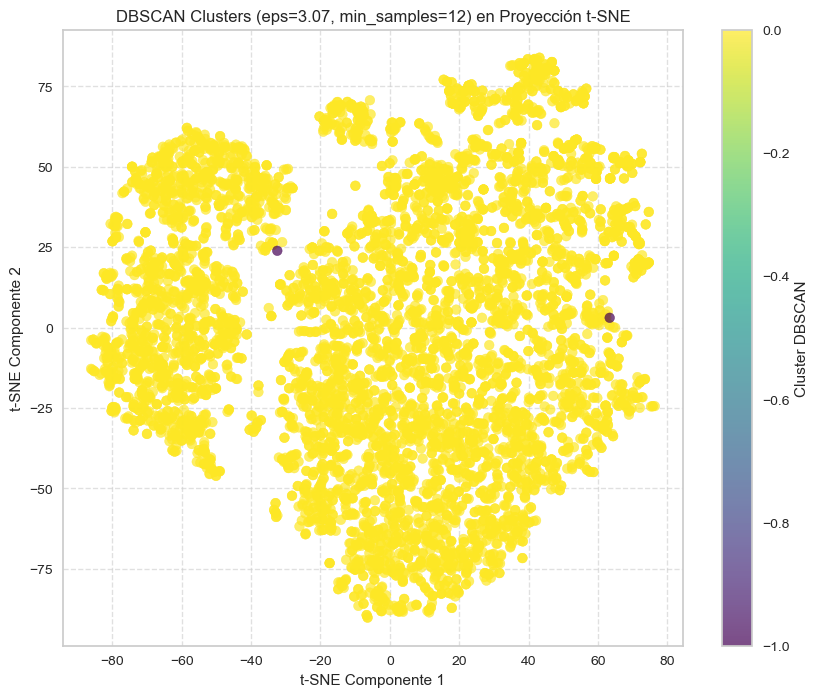

In [68]:
if 'clusters_dbscan' in locals():
    plt.figure(figsize=(10, 8))
    scatter_dbscan_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.7)
    plt.title(f'DBSCAN Clusters (eps={eps_elegido}, min_samples={min_samples_dbscan}) en Proyección t-SNE')
    plt.xlabel('t-SNE Componente 1')
    plt.ylabel('t-SNE Componente 2')
    plt.colorbar(scatter_dbscan_tsne, label='Cluster DBSCAN')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de DBSCAN para obtener 'clusters_dbscan'.")

**Paso 4: Comparación con Tipo de Vino Original.**

    * Crear un `scatter plot` de `X_tsne` coloreado por `y_type`.
    * Añadir título, etiquetas de ejes y una barra de color interpretativa.
    * Comentar las observaciones sobre la separación y la preservación local.

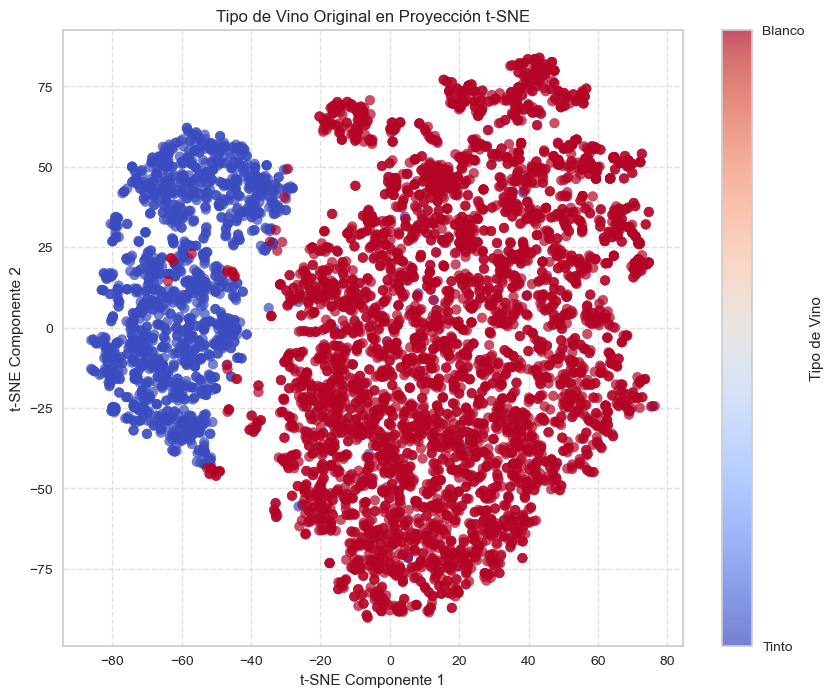

In [69]:
plt.figure(figsize=(10, 8))
scatter_original_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_type, cmap='coolwarm', alpha=0.7)
plt.title('Tipo de Vino Original en Proyección t-SNE')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.colorbar(scatter_original_tsne, ticks=[0, 1], format=plt.FuncFormatter(lambda x, p: 'Tinto' if x==0 else 'Blanco'), label='Tipo de Vino')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

<font color=red>(A COMPLETAR) Comenta aquí tus observaciones sobre la separación con t-SNE</font>

"t-SNE logra [una mejor/peor] separación visual de los clusters/tipos de vino en comparación con PCA, lo que sugiere..."

"Observamos que t-SNE tiende a formar agrupaciones más densas para los clusters..."

<font color='green'>Respuesta:</font>

T-SNE permitió visualizar de manera más clara las estructuras latentes en los datos, complementando el análisis de clustering. La representación muestra dos agrupaciones potenciales: los puntos dentro de cada cluster presentan cohesión interna relativamente uniforme, mientras que los clusters están claramente separados entre sí. Estos hallazgos refuerzan la hipótesis de la existencia de dos clusters subyacentes, alineándose con los resultados obtenidos previamente mediante K-Means.

<a name="umap"></a>
### 5.4. Técnica de Reducción 3: UMAP para Visualización
UMAP (Uniform Manifold Approximation and Projection) es una técnica de reducción de dimensionalidad no lineal más reciente y a menudo más rápida que t-SNE, que busca un balance entre la preservación de la estructura local y global.

#### TAREAS EN EL NOTEBOOK:

**Paso 1: Aplicar UMAP.**

    * Inicializar `umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)` (puedes ajustar `n_neighbors` y `min_dist`).
    * Entrenar y transformar `X_scaled` usando `.fit_transform()`. Guardar en `X_umap`.

In [70]:
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1) # Ajusta parámetros si es necesario

In [71]:
X_umap = reducer.fit_transform(X_scaled)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


**Paso 2: Visualizar Clusters de KMeans en UMAP.**

    * Crear un `scatter plot` de `X_umap` coloreado por `clusters_kmeans`.
    * Añadir título, etiquetas de ejes y una barra de color.

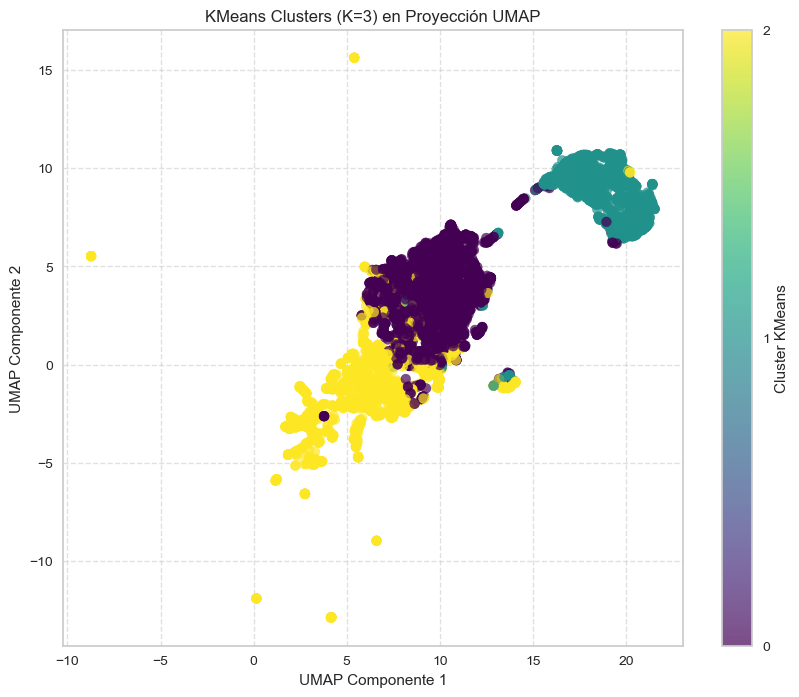

In [72]:
if 'clusters_kmeans' in locals():
    plt.figure(figsize=(10, 8))
    scatter_kmeans_umap = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
    plt.title(f'KMeans Clusters (K={k_elegido}) en Proyección UMAP')
    plt.xlabel('UMAP Componente 1')
    plt.ylabel('UMAP Componente 2')
    plt.colorbar(scatter_kmeans_umap, label='Cluster KMeans', ticks=range(k_elegido))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de KMeans para obtener 'clusters_kmeans'.")

**Paso 3: Visualizar Clusters de DBSCAN en UMAP.**

    * Crear un `scatter plot` de `X_umap` coloreado por `clusters_dbscan`.
    * Añadir título, etiquetas de ejes y una barra de color.

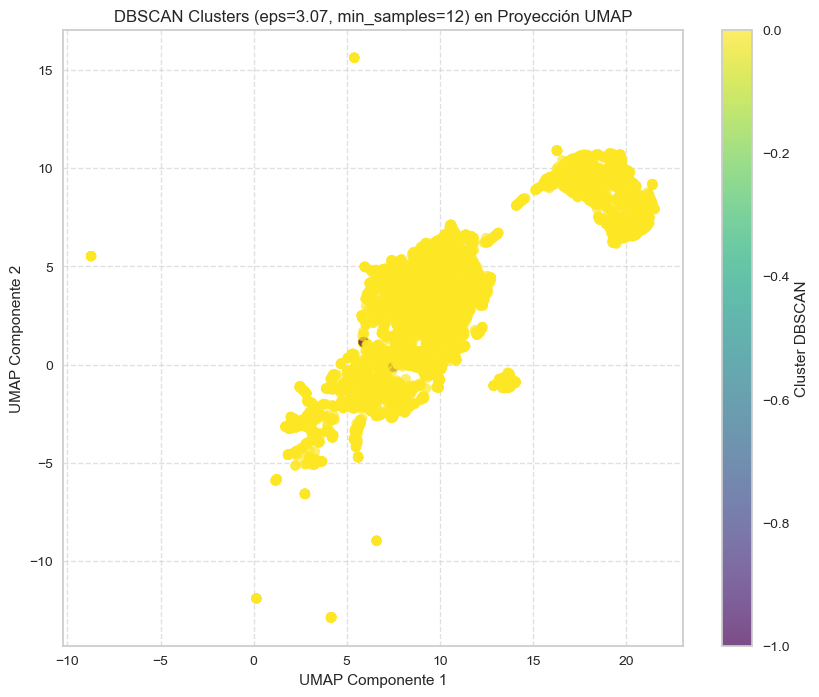

In [73]:
if 'clusters_dbscan' in locals():
    plt.figure(figsize=(10, 8))
    scatter_dbscan_umap = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.7)
    plt.title(f'DBSCAN Clusters (eps={eps_elegido}, min_samples={min_samples_dbscan}) en Proyección UMAP')
    plt.xlabel('UMAP Componente 1')
    plt.ylabel('UMAP Componente 2')
    plt.colorbar(scatter_dbscan_umap, label='Cluster DBSCAN')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de DBSCAN para obtener 'clusters_dbscan'.")

**Paso 4: Comparación con Tipo de Vino Original.**

    * Crear un `scatter plot` de `X_umap` coloreado por `y_type`.
    * Añadir título, etiquetas de ejes y una barra de color interpretativa.
    * Comentar las observaciones sobre la separación, velocidad y preservación global/local.

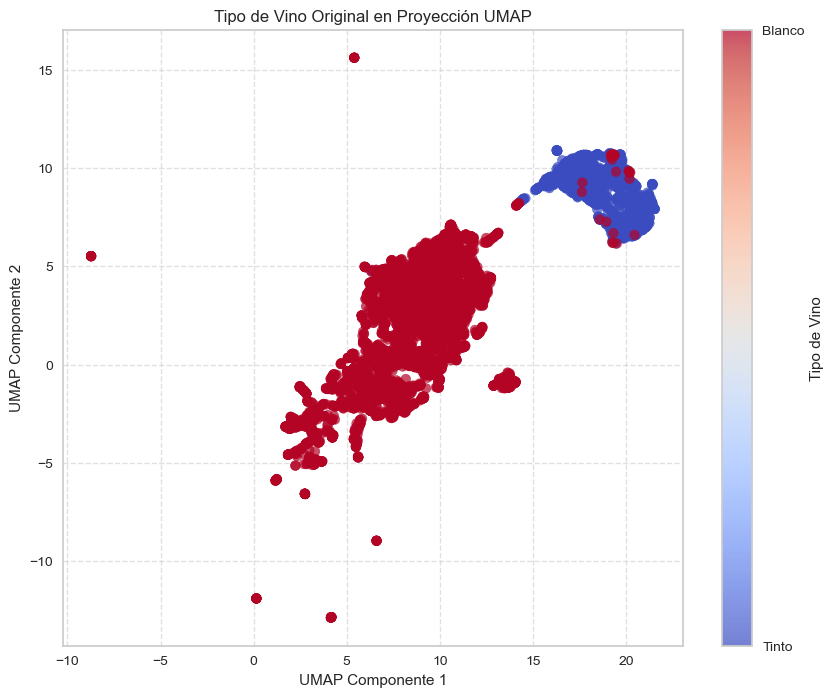

In [74]:
plt.figure(figsize=(10, 8))
scatter_original_umap = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_type, cmap='coolwarm', alpha=0.7)
plt.title('Tipo de Vino Original en Proyección UMAP')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')
plt.colorbar(scatter_original_umap, ticks=[0, 1], format=plt.FuncFormatter(lambda x, p: 'Tinto' if x==0 else 'Blanco'), label='Tipo de Vino')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

<font color=red> (A COMPLETAR) Comenta aquí tus observaciones sobre la separación con UMAP </font>

"UMAP parece ofrecer [una excelente/buena/regular] visualización, con clusters [más compactos/más dispersos] y [mejor/peor] preservación de la estructura global..."

"La separación de los tipos de vino original con UMAP es..."

<font color='green'>Respuesta:</font>

UMAP logra separar casi en su totalidad los grupos correspondientes a las clases reales, aunque se observa un pequeño grupo de puntos que queda aislado como si fuera un tercer mini-cluster, cuando en realidad pertenece al cluster de puntos rojos más cercano. Esto sugiere que ajustar la configuración de UMAP podría mejorar la consistencia de la representación.

En cuanto a la clusterización, se optará por K-Means con K = 2, considerando que las dos agrupaciones principales reflejan la estructura subyacente de los datos. Para determinar si es válido considerar un tercer cluster (tres tipos de vino), se consultará al sector responsable de las variedades de vinos, integrando esta información con un análisis descriptivo de los clusters para tomar una decisión fundamentada en ambos escenarios.

<a name="conclusion_reduccion"></a>
### 5.5. (A COMPLETAR) Tareas Finales de Reducción y Conclusión
Una vez generadas todas las proyecciones visuales, es momento de analizar cuál método nos ofrece la visión más clara, perspicaz y útil de la estructura de nuestros datos y de los clusters encontrados.

#### TAREAS EN EL NOTEBOOK:
1.  **Comparación Visual Exhaustiva:**
    * Vuelvan a revisar todos los gráficos de PCA, t-SNE y UMAP (con clusters de KMeans, DBSCAN y el tipo de vino original).
    * ¿Cuál proyección muestra la mejor separación entre los clusters encontrados por KMeans y DBSCAN?
    * ¿Cuál preserva mejor la separación natural entre vinos tintos y blancos?
    * ¿Observan alguna estructura interesante (sub-grupos, outliers, continuidad) en alguna de las visualizaciones que no era evidente antes?

<font color=red>(A COMPLETAR) Compara aquí las visualizaciones y la separación de clusters/tipos de vino:</font>
```

"Al comparar las proyecciones de PCA, t-SNE y UMAP, se observa que [t-SNE/UMAP/PCA] es el que mejor logra visualizar la separación de los clusters de [KMeans/DBSCAN], mientras que [otro método] es mejor para el tipo de vino original porque..."

"Algunas estructuras interesantes observadas son..."
```

<font color='green'>Respuesta:</font>

Ninguna de las técnicas de reducción de dimensionalidad es mágica ni definitiva; sin embargo, PCA, t-SNE y UMAP se complementan eficazmente como pasos previos al clustering, proporcionando una aproximación de la forma y cantidad de clusters posibles. Esto ayuda a orientar la elección del algoritmo de clustering y la configuración de sus hiperparámetros.

En general, las visualizaciones oscilan entre 2 y 4 clusters, con un énfasis mayor en dos agrupaciones principales. En escenarios donde se tiene conocimiento del dominio, se podría conocer de antemano las posibles agrupaciones ocultas. En estos casos, lo recomendable es primero realizar una separación computacional y posteriormente afinarla mediante análisis descriptivo y manual, para confirmar la estructura final de los clusters.

En los resultados observados, se identifican principalmente dos grupos, aunque uno de ellos muestra fragmentación sutil; en UMAP, esto se refleja como una partición cercana de uno de los clusters, seguida de puntos aislados que se consideran ruido.

Por esta y todas las razones mencionadas a lo largo del analisis, se opta por un número de clusters igual a 2 mediante el algoritmo KMeans.

2.  **Consideraciones de Rendimiento:**
    * Comenten brevemente sobre el tiempo de ejecución aproximado de cada método de reducción de dimensionalidad (PCA es rápido, t-SNE es lento, UMAP intermedio).

<font color=red>(A COMPLETAR) Comentarios sobre el rendimiento:</font>
```

"En términos de velocidad, PCA fue el más rápido, seguido por UMAP. t-SNE fue el más lento, lo cual es de esperar para datasets de este tamaño."
```


<font color ='green'>Respuesta:</font>

En términos de velocidad, considerando la dimensionalidad del conjunto de datos, el orden observado fue: PCA > UMAP > t-SNE. Esto es consistente con la complejidad computacional de cada algoritmo:

- PCA: Calcula la matriz de covarianza y extrae sus vectores y valores propios para la reducción dimensional, lo que lo hace extremadamente rápido (~1 segundo).

- UMAP: También utiliza probabilidades condicionales, pero únicamente considerando los k vecinos más cercanos de cada punto, lo que lo hace significativamente más eficiente que t-SNE (~6 segundos).

- t-SNE: Calcula matrices de cercanía, probabilidad conjunta y condicional entre todos los pares de puntos, lo que genera una complejidad aproximadamente cuadrática o mayor (~14 segundos).


3.  **Justificar:**
    * Escriban una conclusión clara: ¿Qué técnica de reducción de dimensionalidad (PCA, t-SNE o UMAP) consideran más efectiva para **visualizar** la estructura de este dataset de vinos en particular, y por qué?
    * Argumenten su elección basándose en la claridad de los clusters, la preservación de la estructura original y la eficiencia computacional.

<font color=red>(A COMPLETAR) Mi Conclusión sobre la Mejor Técnica de Reducción de Dimensionalidad para Visualización:</font>
```

Basado en [la claridad visual, la preservación de estructuras y el rendimiento], considero que [PCA / t-SNE / UMAP] es la técnica más efectiva para visualizar este dataset porque...

```

<font color='green'>Respuesta:</font>

Las tres técnicas de reducción de dimensionalidad pueden considerarse complementarias; sin embargo, si fuera necesario descartar alguna, t-SNE sería la primera opción. Esto se debe a que, aunque preserva adecuadamente la cohesión local, presenta una alta demanda computacional, no permite reutilizar sus representaciones directamente como entrada en modelos de aprendizaje automático y no garantiza la preservación de la separación entre estructuras latentes.

En segundo lugar, PCA, si bien ofrece una reducción dimensional rápida y eficiente que puede complementar el análisis de clustering, no logra mantener la separación entre las agrupaciones al proyectar los datos en un espacio de baja dimensión.

Por su parte, UMAP considero la técnica de reducción ideal, ya que, aunque resulta más costosa computacionalmente que PCA, preserva tanto la estructura local como la global de los datos. Además, permite visualizar con claridad las agrupaciones latentes subyacentes y utilizar las representaciones reducidas como entrada para modelos de clustering, dado que los datos permanecen bien separados en el espacio de baja dimensión.


<a name="final"></a>
## 6. (A COMPLETAR) Conclusiones Finales del Proyecto
En esta sección final, resume tus hallazgos clave de todo el proyecto integrador del Módulo 3. ¡Es tu oportunidad para mostrar todo lo que aprendiste!

#### TAREAS EN EL NOTEBOOK:

1.  **Resumen de Hallazgos Clave:**
    * ¿Qué descubriste sobre la estructura intrínseca de los datos de vino a través del clustering?
    * ¿Cómo te ayudaron las técnicas de reducción de dimensionalidad a entender mejor estas estructuras? ¿Hubo alguna visualización que te sorprendiera o te diera una nueva perspectiva?
    * ¿Consideras que los clusters encontrados se correlacionan con características significativas del vino (ej. tipo, calidad, otros perfiles no obvios)?

2.  **Desafíos y Aprendizajes:**
    * ¿Cuáles fueron los principales desafíos al trabajar con modelos no supervisados y reducción de dimensionalidad en este dataset?
    * ¿Qué nuevos aprendizajes clave te llevas de este módulo y este proyecto?

3.  **Aplicaciones Futuras:**
    * ¿Cómo crees que estas técnicas no supervisadas podrían aplicarse en escenarios reales de la industria del vino o en otros dominios? (ej. segmentación de clientes, detección de anomalías, descubrimiento de nuevas categorías de productos).


<font color=red>(A COMPLETAR) Tus Conclusiones Finales Aquí:</font>

```
"Este proyecto integrador nos permitió adentrarnos en el mundo del aprendizaje no supervisado, revelando patrones y estructuras ocultas en el dataset de vinos que no serían evidentes con un análisis supervisado tradicional..."

```

<font color='green'>Respuesta:</font>

En general, los clusters identificados presentan estructuras aproximadamente esféricas que se correlacionan con el tipo de vino, diferenciándose claramente entre sí en función de las variables fisicoquímicas disponibles (fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol).

Los principales desafíos del aprendizaje no supervisado radican en que se intenta aproximar soluciones sin certeza absoluta. Ni las métricas, ni la reducción de dimensionalidad, ni el análisis descriptivo manual garantizan resultados perfectos, y en muchos casos la información detallada sobre las agrupaciones reales puede no estar disponible. Esto hace que el proceso sea iterativo, permitiendo ajustar hiperparámetros, alimentar modelos de clustering con datos reducidos o decidir el número de clusters de manera fundamentada a medida que se avanza en el análisis.

En escenarios futuros, la recomendación sería:
1.	Reducir dimensionalidad primero, preferiblemente con técnicas no lineales como UMAP, ya que permiten visualizar la forma y posible número de clusters, además de generar representaciones que pueden servir como entrada para posteriores modelos de clustering.
2.	Aplicar clustering considerando una hipótesis inicial sobre la estructura de los datos, lo que permite orientar el análisis y validar resultados de manera más crítica.
3.	Integrar análisis descriptivo y conocimiento del dominio, para interpretar las agrupaciones de forma fundamentada y mejorar la calidad del análisis en contextos prácticos o industriales.